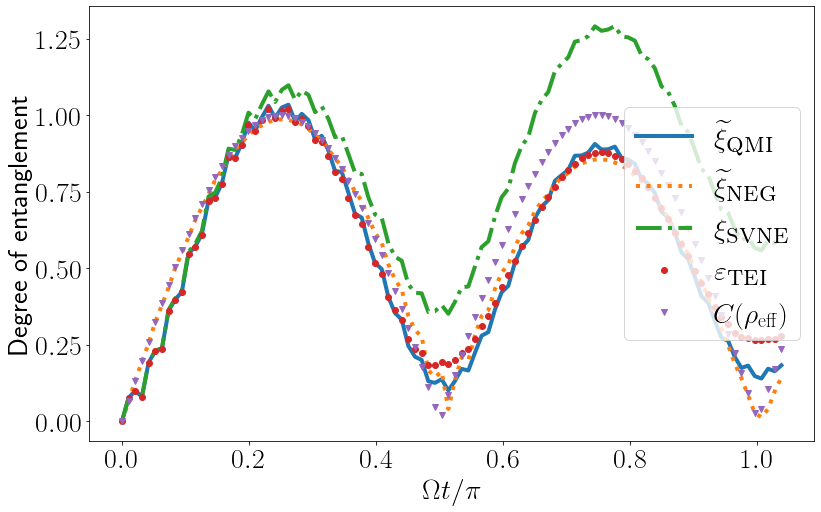

In [1]:
import numpy as np
import re ##Regular Expression##Pattern matching functions
from scipy.stats import binom
import math
import multiprocessing as mp
from qutip import *
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from qutip.qip.operations import *
from qutip.qip.circuit import *
import EntanglementIndicators
basis_list = []
for i in range(2):
    for j in range(2):
        for l in range(2):
            for m in range(2):
                basis_list.append(tensor(basis(2,i), basis(2,j), basis(2,l), basis(2,m)))
d1up = tensor(sigmam(), qeye(2), qeye(2), qeye(2));
d1dw = tensor(sigmaz(), sigmam(), qeye(2), qeye(2));
d2up = tensor(sigmaz(), sigmaz(), sigmam(), qeye(2));
d2dw = tensor(sigmaz(), sigmaz(), sigmaz(), sigmam());
d1up_d = d1up.dag();
d1dw_d = d1dw.dag();
d2up_d = d2up.dag();
d2dw_d = d2dw.dag();
n1up = d1up_d * d1up;
n1dw = d1dw_d * d1dw;
n2up = d2up_d * d2up;
n2dw = d2dw_d * d2dw;
iota=complex(0,1.);
###########################################################
#####Initial value#############
Delta=0.05;
gamma=0.005;
J=4; 
Jl=1; 
DeltaZ1=0.5; 
DeltaZ2=0.5;
initState=ket2dm(basis_list[9]);
tsteps=100;
tmin=0.;
tmax=460.*np.pi;
precision=1E-10;
time_insts=np.linspace(tmin,tmax,tsteps);
###DecohOps###
AnnOps=[d1up,d1dw,d2up,d2dw];
DecohGamma=1E-4;
DecohOps=[]
for i in range(len(AnnOps)):
    DecohOps.append(np.sqrt(DecohGamma)*AnnOps[i])
###########################################################
Hs = Delta * (d1up_d * d2dw_d - d1dw_d * d2up_d);
Hct = gamma * (d1up_d * d2up + d1dw_d * d2dw);
Hc = J * (n1up * n1dw + n2up * n2dw);
Hc_2 = Jl * (n1up * n2up + n1up * n2dw);
Hc_2 = Hc_2 + Jl * (n1dw * n2up + n1dw * n2dw);
Hz = (DeltaZ1 / 2) * (n1up - n1dw);
Hz= Hz + (DeltaZ2 / 2) * (n2up - n2dw);
HamOp = Hs + Hs.dag() + Hct + Hct.dag() + Hc + Hc_2 + Hz;
TimeEvol=mesolve(HamOp,initState,time_insts,c_ops=[DecohOps[0],DecohOps[3]]);
OperatorList=[n1up*n2dw,n1up,n2dw];
############################################################
NExpectVals=[[0 for j in range(len(TimeEvol.states))] for i in range(3)];
for i in range(3):
    for j in range(len(TimeEvol.states)):
        AverCompute=OperatorList[i]*TimeEvol.states[j];
        ExpValComplex=sum([AverCompute.data[k,k] for k in range(16)]);
        ExpValReal=np.real(ExpValComplex);
        ExpValImag=np.imag(ExpValComplex);
        if(abs(ExpValImag)>precision):
            print("Complex Exp value for Hermitian operator",AverCompute.data[0,0]);
            exit()
        NExpectVals[i][j]=ExpValReal;
############################################################
ComputeEntanglement=EntanglementIndicators.Entanglement(TimeEvol.states,16,2,1E-7);
QMIs=ComputeEntanglement.QMI_compute();
SVNEs=ComputeEntanglement.SVNE_compute();
Negs=ComputeEntanglement.negativity_compute();
NegA=[Negs[2*i] for i in range(tsteps)]
TEIs=ComputeEntanglement.TEI_compute();
SingleProjTEIs=ComputeEntanglement.SingleProj_TEI_compute('zzzz');
##Plotting Variance###
time_insts=np.linspace(tmin,tmax,tsteps);
VarianceList=[NExpectVals[0]-np.multiply(NExpectVals[1],NExpectVals[2])];
##Plotting Entanglement indicators##
RedQMIs=[QMIs[i]/2. for i in range(int(len(time_insts)))]
RedNegA=[NegA[i]*2. for i in range(int(len(time_insts)))]
RedSVNEs=[SVNEs[i] for i in range(int(len(time_insts)))]
RedTEIs=[SingleProjTEIs[i] for i in range(int(len(time_insts)))]
############################################################
###Plotting Occupation expectation values###
rc('font',**{'family':'sans-serif','sans-serif':['Helvatica'], 'size': 28})
rc('text',usetex=True)
LineStyles=['-',':','-.','o','v','*','+','s','x']
Omega=np.abs(-Delta*Delta*((1./Jl)-(1./((2.*J)+(3.*Jl))))-(2.*gamma*gamma/(Jl-J)));
scaled_time=np.linspace((Omega/(np.pi))*tmin,(Omega/(np.pi))*tmax,tsteps);
EffStates=[np.cos(np.pi*scaled_time[i])*np.cos(np.pi*scaled_time[i])*ket2dm(basis([2,2],[0,1]))
           +np.sin(np.pi*scaled_time[i])*np.sin(np.pi*scaled_time[i])*ket2dm(basis([2,2],[1,0]))
           +iota*np.cos(np.pi*scaled_time[i])*np.sin(np.pi*scaled_time[i])*(basis([2,2],[0,1])*basis([2,2],[1,0]).dag())
           -iota*np.cos(np.pi*scaled_time[i])*np.sin(np.pi*scaled_time[i])*(basis([2,2],[1,0])*basis([2,2],[0,1]).dag())
           for i in range(tsteps)];
C=[concurrence(EffStates[i]) for i in range(tsteps)];
NegEff=[2.*negativity(EffStates[i],0,method='eigenvalues') for i in range(tsteps)];
fig,axtr=plt.subplots(1,1,figsize=(13, 8))
axtr.plot(scaled_time,RedQMIs,LineStyles[0],linewidth=4)
axtr.plot(scaled_time,RedNegA,LineStyles[1],linewidth=4)
axtr.plot(scaled_time,RedSVNEs,LineStyles[2],linewidth=4)
axtr.plot(scaled_time,RedTEIs,LineStyles[3],linewidth=4)
axtr.plot(scaled_time,C,LineStyles[4],linewidth=5)
#axtr.plot(scaled_time,NegEff,LineStyles[5],linewidth=5)
axtr.set_xlabel(r'$\Omega t/\pi$');
axtr.set_ylabel('Degree of entanglement');
axtr.legend([r'$\widetilde{\xi}_{\textsc{qmi}}$',r'$\widetilde{\xi}_{\textsc{neg}}$',r'$\xi_{\textsc{svne}}$',r'$\varepsilon_{\textsc{tei}}$',r'$C(\rho_{\mathrm{eff}})$'],loc='right');
plt.show()
fig.savefig('fig_4_new.pdf')